In [5]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go

def fetch_data(ticker, start_date='2021-01-01', end_date='2024-01-01'):
    """Fetch historical data for the given ticker."""
    return yf.download(ticker, start=start_date, end=end_date)

def ewmac(price, vol, Lfast, Lslow):
    """
    Calculate the ewmac trading rule forecast, given a price, volatility and EWMA speeds Lfast and Lslow

    Assumes that 'price' and vol is daily data

    This version uses a precalculated price volatility, and does not do capping or scaling

    :param price: The price or other series to use (assumed Tx1)
    :type price: pd.Series

    :param vol: The daily price unit volatility (NOT % vol)
    :type vol: pd.Series aligned to price

    :param Lfast: Lookback for fast in days
    :type Lfast: int

    :param Lslow: Lookback for slow in days
    :type Lslow: int

    :returns: pd.Series -- unscaled, uncapped forecast
    """
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()


def calculate_ewmac_signals(data, parameters):
    """
    Calculate EWMAC signals for a given price series, volatility, and a list of parameters.

    :param price: The price series
    :type price: pd.Series

    :param volatility: The volatility series
    :type volatility: pd.Series

    :param parameters: List of tuples containing fast and slow parameters
    :type parameters: list of tuples

    :returns: pd.DataFrame -- DataFrame containing EWMAC signals for each parameter pair
    """
    for filter_speed in parameters:
        data[f'EWMAC_{filter_speed}'] = scale_cap_forecast(ewmac(data['Close'], data['Volatility'], filter_speed, 4*filter_speed))
    return data


def scale_cap_forecast(signals, cap=20):
    """
    Scale the forecast so it has an expected absolute average value of 10.

    :param signals: EWMAC signals.
    :return: Scaled signals.
    """
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)
    
def plot_position_size(position_size, price):
    """
    Plot position size against underlying price with vertical lines indicating periods of long and short positions.

    :param position_size: Position size data.
    :param price: Underlying price data.
    """
    fig = go.Figure()

    # Plot underlying price
    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')))

    # Create a separate y-axis for position size
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))

    # Add fill areas for long and short positions
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    # Add vertical lines for direction change
    for i in range(1, len(position_size)):
        if position_size.iloc[i] != 0 and position_size.iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    # Set layout
    fig.update_layout(title='Position Size vs Underlying Price with Direction Change Indicators', xaxis_title='Date')

    # Ensure both y-axes share y=0
    fig.update_layout(yaxis=dict(title='Price', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def plot_position_size_vs_pnl(position_size, price):
    """
    Plot position size against PNL with vertical lines indicating periods of long and short positions.

    :param position_size: Position size data.
    :param pnl: Profit and Loss data.
    """
    pnl = (calculate_pnl(position_size, price)).cumsum()
    fig = go.Figure()

    # Plot PNL
    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='blue')))

    # Create a separate y-axis for position size
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))

    # Add fill areas for long and short positions
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    # Add vertical lines for direction change
    for i in range(1, len(position_size)):
        if position_size.iloc[i] != 0 and position_size.iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    # Set layout
    fig.update_layout(title='Position Size vs PNL with Direction Change Indicators', xaxis_title='Date')

    # Ensure both y-axes share y=0
    fig.update_layout(yaxis=dict(title='PNL', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()


In [221]:
def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    """
    Calculate the position size based on capped signals, risk target, and other parameters.

    :param capped_signals: DataFrame containing capped EWMAC signals.
    :param risk_target: Annualized risk target.
    :param volatility: Current volatility of the instrument.
    :param price: Current price of the instrument.
    :param capital: Total capital available for trading.
    :param instrument_weights: Weights of instruments in the portfolio.
    :param fx_rate: Exchange rate if applicable.
    :param IDM: Instrument Diversification Multiplier.
    :return: Position size.
    """
    multiplier = 1000
    # Calculate the average of capped signals
    average_signal = capped_signals.mean(axis=1)
    
    # Calculate risk-adjusted unrounded position
    position = average_signal * capital * idm * instrument_weights * risk_target / (10 * multiplier * price * fx_rate * volatility)
    
    return position

def calculate_pnl(position_size, prices, multiplier=1000):
    return (position_size * prices * 1000).replace(0.0, np.nan).dropna()

def calculate_backtest_metrics(data, capital, strat):
    """
    Calculate various backtest metrics based on position size and price data.

    :param position_size: Series containing position size data.
    :param price_data: Series containing price data.

    :return: Dictionary containing backtest metrics.
    """
    # Calculate P&L (Profit and Loss)
    pnl = calculate_pnl(data['Position Size'], data['Daily_Returns'])
    
    # Calculate cumulative P&L
    cumulative_pnl = pnl.cumsum()

    # Calculate Sharpe ratio
    sharpe_ratio = pnl.mean() / pnl.std() * (252 ** 0.5)

    # Calculate annualized return
    annualized_return = pnl.mean() * 252

    annualized_return_pct = annualized_return*100/capital

    annualized_return_pct = pnl.pct_change().mean() * 252

    # Additional metrics
    drawdowns = (cumulative_pnl - cumulative_pnl.expanding().max())
    avg_drawdown = drawdowns.mean()

    # Calculate average position size
    avg_position = data['Position Size'].abs().mean()
    turnover = (data['Position Size'].diff().abs() / avg_position).sum()
    skew = pnl.skew()
    lower_tail = pnl.quantile(0.05)
    upper_tail = pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * (252 ** 0.5)
    
    return pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Avg Drawdown %": avg_drawdown,
        "Annual Standard Deviation %": pnl.pct_change().dropna().std() * (252 ** 0.5),
        "Sharpe Ratio": sharpe_ratio,
        "Turnover": turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        # "Alpha": alpha,
        "Cumulative PnL": cumulative_pnl.iloc[-1]
    }, index=[strat]).T

def backtest(ticker = 'BZ=F', start_date = '2020-01-01', end_date = '2024-01-01', parameters = [4, 8, 16, 32, 64],
             risk_target = 0.25, capital = 100000, plot=True):
    strat = "EWMAC_"  + '_'.join([str(i) for i in parameters])
    instrument_weights = 1 # Example instrument weights
    fx_rate = 1.0  # Example exchange rate if applicable
    idm = 1  # Example Instrument Diversification Multiplier

    # Fetch data
    data = fetch_data(ticker, start_date, end_date)

    # Calculate daily returns
    data['Daily_Returns'] = data['Close'].pct_change()

    # Calculate volatility
    data['Volatility'] = data['Daily_Returns'].ewm(span=30, min_periods=0).std()

    # Calculate EWMAC signals (scaled and capped)
    data = calculate_ewmac_signals(data, parameters)
    signal_cols = [i for i in data.columns if "EWM" in i]

    # Calculate position size
    data["Position Size"] = calculate_position_size(data[signal_cols], risk_target, data['Volatility'], data['Close'], capital, instrument_weights, fx_rate, idm)

    backtest_metrics = calculate_backtest_metrics(data, capital, strat)
    
    pd.options.display.float_format = '{:.2f}'.format  # Adjust precision as needed
    # Print the calculated metrics
    print(backtest_metrics.round(2))

    if plot==True:
        plot_position_size(data["Position Size"], data['Close'])
        plot_position_size_vs_pnl(data["Position Size"], data['Close'])


    return data


In [222]:
data = backtest(plot=False)
# data

[*********************100%%**********************]  1 of 1 completed

                              EWMAC_4_8_16_32_64
Initial Capital                        100000.00
Mean Annualised Return  %                 -99.88
Avg Drawdown %                          -1084.22
Annual Standard Deviation %              2435.22
Sharpe Ratio                                2.14
Turnover                                  110.44
Skew                                        0.78
Lower Tail (5th percentile)              -440.70
Upper Tail (95th percentile)              599.54
Cumulative PnL                          44812.54


In [223]:
ps, px = data['Position Size'], data['Close']

In [225]:
pnl = (ps * px.pct_change() * 1000).dropna().replace(0.0, np.nan).interpolate()
pnl

Date
2020-01-06      4.10
2020-01-07     -5.71
2020-01-08     19.84
2020-01-09      1.29
2020-01-10     12.46
               ...  
2023-12-22     29.47
2023-12-26   -124.32
2023-12-27     87.50
2023-12-28     99.17
2023-12-29    145.03
Length: 1002, dtype: float64

In [232]:
pnl.pct_change()

Date
2020-01-06     NaN
2020-01-07   -2.39
2020-01-08   -4.48
2020-01-09   -0.93
2020-01-10    8.65
              ... 
2023-12-22    0.04
2023-12-26   -5.22
2023-12-27   -1.70
2023-12-28    0.13
2023-12-29    0.46
Length: 1002, dtype: float64

(array([   3.,   11.,   67.,  564., 1166.,  148.,   33.,    7.,    3.,
           2.]),
 array([-1876.14555759, -1418.63825726,  -961.13095694,  -503.62365661,
          -46.11635629,   411.39094404,   868.89824436,  1326.40554469,
         1783.91284501,  2241.42014534,  2698.92744566]),
 <BarContainer object of 10 artists>)

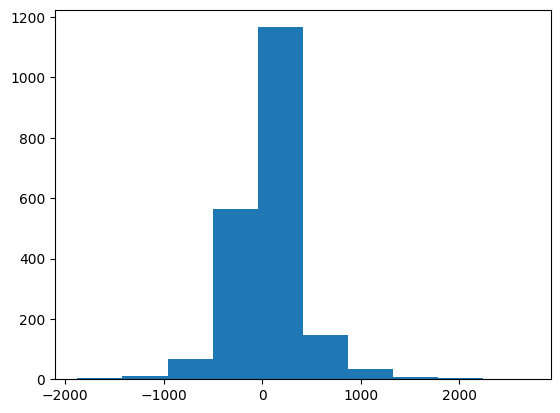

In [187]:
plt.hist(pnl)